In [2]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import  matplotlib.pyplot as plt
from pylift import TransformedOutcome
pd.set_option('display.max_colwidth', None)

<h2> Data </h2>  To explore the features of the pylift  package data from 
Lalonde dataset which was used to evaluate propensity score in the paper:

Dehejia, R., & Wahba, S. (1999). Causal Effects in Nonexperimental Studies: Reevaluating the Evaluation of Training Programs. Journal of the American Statistical Association, 94(448), 1053-1062. doi:10.2307/2669919

http://sekhon.berkeley.edu/matching/lalonde.html



<h2>Data Preparation </h2>
We read in the data in the same was as suggested by the authors of the pylift package. The dataset was suggested for the purpose of the package exploration.  

The treatment and control group data is avaible separatly therefore the two datasets need to be concatinated. 

In [3]:
cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']

control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep='\s+', header = None, names = cols)

treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep='\s+', header = None, names = cols)

lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)


The earnings from 1974 ($re74$) and 1975 ($re75$) are reported in real value. For the analysis we interested in whether person had any earning in those years or not. Therefore we create two dummy variables. The same approach is used for the outcome of interest, which is real earnings in 1978 ($re78$). 

In [4]:
lalonde_df['u74'] = np.where(lalonde_df['re74'] == 0, 1.0, 0.0) 
lalonde_df['u75'] = np.where(lalonde_df['re75'] == 0, 1.0, 0.0)

df = lalonde_df[['nodegr', 'black', 'hisp', 'age', 'educ', 'married', 'u74', 'u75', 'treat', 're78']].copy()

df.rename(columns={'treat':'Treatment', 're78':'Outcome'}, inplace=True)

df['Outcome'] = np.where(df['Outcome'] > 0, 1.0, 0.0)

<h2>Data Exploration </h2>

In [5]:
df.head()
df.describe()

,nodegr,black,hisp,age,educ,married,u74,u75,Treatment,Outcome
count,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,0.782022,0.833708,0.08764,25.370787,10.195506,0.168539,0.732584,0.649438,0.415730,0.692135
std,0.413337,0.372762,0.28309,7.100282,1.792119,0.374766,0.443109,0.477683,0.493402,0.462130
min,0.000000,0.000000,0.00000,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.00000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.00000,24.000000,10.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,0.00000,28.000000,11.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.00000,55.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
pd.crosstab(df['Outcome'], df['Treatment'], margins = True, margins_name= "Total")

Treatment,0.0,1.0,Total
Outcome,,,
0.0,92,45,137
1.0,168,140,308
Total,260,185,445


In [7]:
pd.crosstab(df['Outcome'], df['Treatment'], margins = True, margins_name= "Total", normalize= True)

Treatment,0.0,1.0,Total
Outcome,,,
0.0,0.206742,0.101124,0.307865
1.0,0.377528,0.314607,0.692135
Total,0.584270,0.415730,1.000000


<h2> Uplift Modeling </h2>
For the Uplift modelling we have chosen two methods : 


In [9]:
uplift1 = TransformedOutcome(df, col_treatment='Treatment', col_outcome='Outcome', stratify=df['Treatment'])

uplift1.randomized_search(n_iter=20, n_jobs=10, random_state=1)

uplift1.shuffle_fit(params=uplift1.rand_search_.best_params_, nthread=30, iterations=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.1s finished
Seed 0 finished.
Seed 1 finished.
Seed 2 finished.
Seed 3 finished.
Seed 4 finished.


{0: <pylift.methods.derivatives.TransformedOutcome at 0x12bb74190>,
 1: <pylift.methods.derivatives.TransformedOutcome at 0x12bb7c5e0>,
 2: <pylift.methods.derivatives.TransformedOutcome at 0x12c4f77f0>,
 3: <pylift.methods.derivatives.TransformedOutcome at 0x12bba4130>,
 4: <pylift.methods.derivatives.TransformedOutcome at 0x12c4f7f40>}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


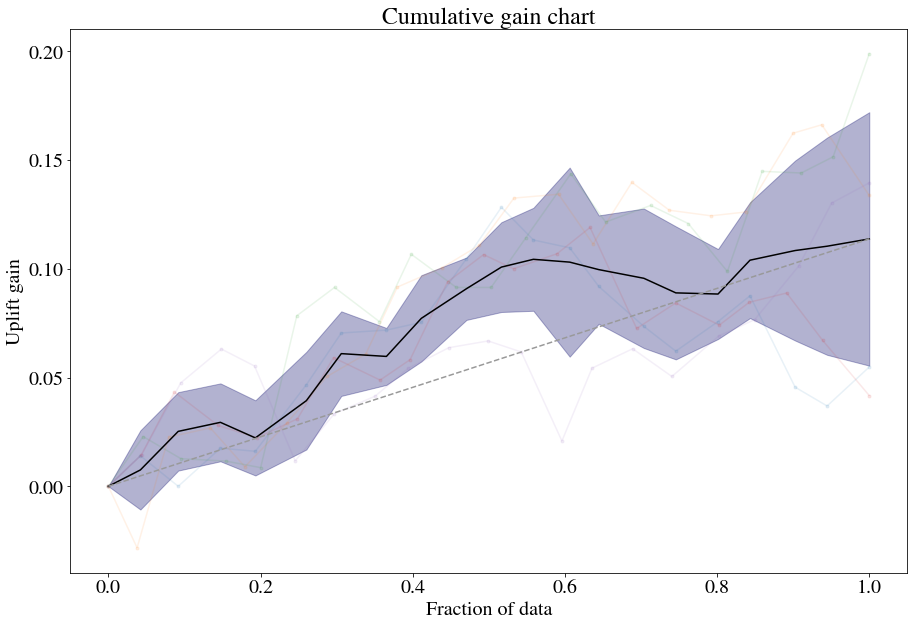

In [10]:
uplift1.plot(show_shuffle_fits=True)

In [18]:
uplift2 = TransformedOutcome(df, col_treatment='Treatment', col_outcome='Outcome', sklearn_model= 'RandomForestRegressor')

grid_search_params = {
    'estimator': RandomForestRegressor(),
    'param_grid': {'min_samples_split': [2,3,5,10,30,100,300,1000,3000,10000]},
    'verbose': True,
    'n_jobs': 35,
}

uplift2.grid_search(**grid_search_params)
uplift2.plot()

TypeError: 'str' object is not callable